## An explanation of IMS's map projection:

I feel the need to clarify how the [National Ice Center's Interactive Multisensor Snow and Ice Mapping System (IMS)](http://nsidc.org/data/docs/noaa/g02156_ims_snow_ice_analysis/index.html) generates their maps. 

But first a little background. The IMS project has been uploading zipped .asc files daily since 1997. From the start, they were using a 24x24 km grid. Since 2004, they have improved their measurement methods and process and implemented a 4x4 km resolution grid. Lastly, 2014 saw further improvements with a 1x1 km resolution map. Below is a picture was taken from their website. 

<img src="figures/ims_earth.gif",width=400>

One question posed is the meaning behind these resolutions. Does each cell represent an nxn km area? Spoiler alert. It doesn't. If so, what does this number signify? This following post will attempt to answer this question.

Let's start with map projections. The IMS uses a Stereographic projection. All projections seek to transform a 3d surface, such as the Earth, moon, asteroid, onto a 2d surface. 

If you have ever tried wrapping a piece of paper around an apple (try it out now if you haven't), you will find that it is impossible to wrap it so that there are no wrinkles or bulges. A projection is a similar procedure only in reverse. And like that paper, the spheroid will have its surface areas grow and shrink accordingly. A gross example is the Mercator projection, which shows Greenland as a huge continent when in reality it's about the size of Mexico. So how does the Stereographic projection distort our Earth?

The Polar Stereographic projection chooses a latitude, whose scale doesn't change. In the IMS's case, $60^{\circ}N$. The projection will dilate the points outside of it. Points below $60^{\circ}N$ are stretched further apart, and points further north are pushed closer together. What you end up with is a distorted map with a scrunched up north pole and a stretched out equator. Take a look at this projection. Africa isn't that large, right?

<img src="figures/stereographic_proj.JPG",width=400>

Another way of thinking about it is that we fit a sphere onto a plane tangent to the north pole. As project further away from the pole, our distance increases. See how the distance between the lines on the plane increase as the angle increases.

<img src="figures/sphere_proj.png",width=700>

Let's take a look at the IMS data. Each day consists of a file of n rows and n columns. We have in effect an x,y grid, instead of a latitude-longitude (lat-lon) grid. Transforming the grid to lat-lon has the *reverse* effect. Points that are below $60^{\circ}N$ are closer together, and points above $60^{\circ}N$ are further apart. Bringing it back to the resolution, only the points that fall on $60^{\circ}N$ are what is advertised. For example, the 24x24 km data set has a resolution of 24km only at $60^{\circ}N$. Therefore, most of the distances between the points are *smaller*. 

This non-uniformity is a source of confusion that can lead to overestimating errors in snowfall. [This post](http://www.itsonlyamodel.us/Tibet-Snow-Man.html) seeks to describe how the square kilometer measurements of snow and ice coverage are generated. However, it does not explain the nature of the provided projection. It instead relies on the lat-lon files provided by the IMS. 

I looked into how the lat-lon files were generated, and see that they rely on modeling the earth as an ellipse called the [World Geodetic System 1984 ellipse, orWGS-84](https://en.wikipedia.org/wiki/World_Geodetic_System) for the 4x4 and 1x1 resolution sets. For those irredeemable nerds out there, I provided some derivations that help explain what is going on. All of the formulas are taken from [John Snyder's fantastic book on map projections](https://pubs.er.usgs.gov/publication/pp1395), I even borrowed some of his figures used earlier in this blog. 

## Derivation of Stereographic grids

### Earth modeled as a sphere:

In the case of 24x24km, the Earth is modeled as a sphere with radius $R= 6371.2000 km$

Points, x,y on a Cartesian grid projection are given by the expressions below

\begin{equation}
x = 2R \ k_0 \ tan (\frac{\pi}{4} - \frac{\phi}{2}) sin (\lambda - \lambda_{0} )
\end{equation}
\begin{equation}
y = -2R \ k_0 \ tan (\frac{\pi}{4} - \frac{\phi}{2})cos(\lambda - \lambda_{0})]
\end{equation}
and the scale factor, $k$ is defined as
\begin{equation}
k = \frac{2k_{0}}{1+sin(\phi)}
\end{equation}

$\lambda_{0}$ is the designated center point. In this case $\lambda_{0} = 80^{\circ}$. $k$ is the scale factor. The stereographic projection is conformal, such that k is fixed for a given latitude, $\phi$, as shown by the formula. 

So far, I just took these equations from [Snyder's book](https://pubs.er.usgs.gov/publication/pp1395) page 158. Our center point is the north pole, with the $80^{\circ}$ meridian directly below it, we can simplify these formulas with this information. $\lambda_{0} = 80^{\circ}$, $\phi_{1} = 90^{\circ}$. Let's also take a look at the scaling factor k. We want $k=1$ at $60^{\circ}= \frac{\pi}{3}$. Or

\begin{equation}
k = 1 = \frac{2k_{0}}{1+sin(\phi=\frac{\pi}{3})}
\end{equation}

Solving for $k_{0}$, while knowing that $sin(\frac{\pi}{3})= \frac{\sqrt{3}}{2}$ we get

\begin{equation}
k_0 = \frac{1+\frac{\sqrt{3}}{2}}{2}
\end{equation}

We can now simplify k to

\begin{equation}
k = \frac{1+\frac{\sqrt{3}}{2}}{1+sin(\phi)}
\end{equation}

We can now create our map with a given set of lat-lon points. But what if we want more? More importantly, how can we convert xy coordinates back to lat-lon? We can get lat-lon points is by taking the inverse of the formulas and solving for $\lambda$ and $\phi$

\begin{equation}
\lambda = \lambda_{0} + arctan(x \ / \ (-y))
\end{equation}
\begin{equation}
\phi = arcsin(cos(c))
\end{equation}

Where $c$ is the angle between the x,y point and the origin (south pole).

\begin{equation}
c = 2 \ arctan(\frac{\rho}{2Rk_{0}})
\end{equation}
\begin{equation}
\rho = (x^2 + y^2)^{\frac{1}{2}}
\end{equation}

The formulas are nice and explicit; now there is nothing stopping us from making a grid! Let's move on to some python code that creates grids and plots them over a basemap.

### Python code to test our spherical polar stereographic projection

I'd now like to try and recreate some scaling to test out our functions. The cells below are written in Python 2.7.

In [319]:
#First I import libraries

%matplotlib inline 
from mpl_toolkits.basemap import Basemap
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='monospace', size = 20)
rc('text', usetex=True)
rcStyle = {"font.size":22,
           "axes.titlesize":22,
           "axes.labelsize":22,
           'xtick.labelsize':12,
           'ytick.labelsize':12}
sns.set_context("paper", rc=rcStyle)

from math import radians, degrees
colors = ["windows blue", "amber", "scarlet", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))
import pdb

In [83]:
#Next I define the functions, nestled in a class.

class polar_stereographic_sphere():
    
    def __init__(self,R, k_0, lam_0,grid_size):
        
        self.R = R
        self.k_0 = k_0
        self.lam_0 = lam_0
        self.grid_size = grid_size

    def x_convert(self, phi, lam):
        x = -2*self.R*self.k_0*np.tan(np.pi/4-phi/2)*np.sin(lam-self.lam_0)
        return x

    def y_convert(self, phi, lam):
        y = 2*self.R*self.k_0*np.tan(np.pi/4-phi/2)*np.cos(lam-self.lam_0)
        return y

    def phi_convert(self,x,y):
        c = self.calculate_c(x,y)
        phi = np.arcsin(np.cos(c))
        return phi

    def lam_convert(self,x,y):
        lam = self.lam_0 + np.arctan2(x,(-y))
        return lam

    def calculate_c(self,x,y):
        c = 2*np.arctan(self.calculate_rho(x,y) / (2*self.R*self.k_0))
        return c

    def calculate_rho(self,x,y):

        rho = np.sqrt(x**2 + y**2)

        return rho

In [84]:
#I define some points on a grid 
R = 6371.2000 #in km
k_0 = (1+np.sqrt(3))/2.0 #unitless
lam_0 = 4*np.pi/9 #radians
grid_size = 11

#one is a cartesian grid, evenly spaced
y = np.linspace(-2*R,2*R,grid_size)
x = np.linspace(-2*R,2*R, grid_size)
xx,yy=np.meshgrid(x,y)

#another is a lat-lon grid, evenly spaced
phi = np.linspace(0, np.pi/2, grid_size)
lam = np.linspace(0, 2 * np.pi, grid_size)
phi_phi,lam_lam=np.meshgrid(phi,lam)

In [85]:
# I can now transform my grids and transform them back.
ps = polar_stereographic_sphere(R, k_0, lam_0,grid_size)

#cartesian operations
phi_converted = ps.phi_convert(xx,yy)
lam_converted = ps.lam_convert(xx,yy)
lat_converted = np.round(np.rad2deg(phi_converted),2)
lon_converted = np.round(np.rad2deg(lam_converted),2)
xx_reconstructed = ps.x_convert(phi_converted,lam_converted)
yy_reconstructed = ps.y_convert(phi_converted,lam_converted)

#lat-lon operations
x_converted = ps.x_convert(phi_phi,lam_lam)
y_converted = ps.y_convert(phi_phi,lam_lam)
xx_converted = np.round(x_converted,2)
yy_converted = np.round(y_converted,2)
phi_reconstructed = ps.phi_convert(x_converted,y_converted)
lam_reconstructed = ps.lam_convert(x_converted,y_converted)

In [86]:
#define basemap
m = Basemap(projection='npstere',boundinglat=0,lon_0=-80,resolution='l', lat_ts = 60)

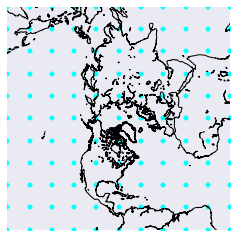

In [87]:
#look at xx,xx on basemap
xx_m = xx_reconstructed.flatten()*1000 + (m.xmax-m.xmin)/2.
yy_m = yy_reconstructed.flatten()*1000 + (m.ymax-m.ymin)/2.
m.scatter(xx_m,yy_m, marker='o',color='cyan')
m.drawcoastlines()

All I did was create a uniform grid. I converted them to latitude-longitude and back into x,y to check my formulas. If we check the distances between the x,y points we will see that it is uniform.

In [88]:
print( np.diff(xx[grid_size/2,:]))

[ 2548.48  2548.48  2548.48  2548.48  2548.48  2548.48  2548.48  2548.48
  2548.48  2548.48]


If we check the distances between the lat points, we see this is not the case. 

In [89]:
print( np.diff(lat_converted[grid_size/2,:]))

[ 11.7   13.28  14.79  15.98  16.66 -16.66 -15.98 -14.79 -13.28 -11.7 ]


I expect this to happen because of equation (8).

$$
\Delta \phi = \phi_{i+1} - \phi_{i} \ne C\Delta x
$$

For some constant C. It depends on where x is located.

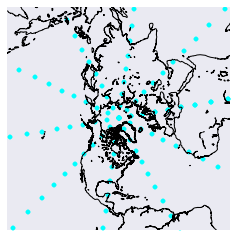

In [90]:
#look at lat-lon grid on basemap

xx_m = xx_converted.flatten()*1000 + (m.xmax-m.xmin)/2.
yy_m = yy_converted.flatten()*1000 + (m.ymax-m.ymin)/2.

m.scatter(xx_m,yy_m, marker='o',color='cyan')
m.drawcoastlines()

See how the points spread out as they approach the equator. Looking at the distances between latitude, we can see that they are uniform.

In [91]:
print( np.diff(phi_phi[grid_size/2,:]))

[ 0.15707963  0.15707963  0.15707963  0.15707963  0.15707963  0.15707963
  0.15707963  0.15707963  0.15707963  0.15707963]


Differences between the cartesian points are non-uniform. Again, points away from the poles spread out, and points close to the poles clump together.

In [92]:
print( np.diff(xx_converted[grid_size/2,:]))

[ 2501.35  2186.26  1949.76  1770.35  1633.83  1530.68  1454.34  1400.4
  1365.93  1349.1 ]


### Earth modeled as the WGS-84 ellipse

These American football (or rugby ball) shaped objects better model the Earth. For smaller resolutions such as the 4x4 and 1x1, computing the grid using a sphere will lead to errors ranging in the hundreds of meters. 

The major axis, in this case, is along the equator. The Earth is fatter along the equator by a few hundred meters. There are many estimations, and the WGS-84 ellipsoid is the one IMS uses.

The WGS-84 has its radius set to $6378.137$ km at the equator and flattening factor f = 1/298.257223563 polar semi-minor axis $b=a(1 − f)$, or $6356.7523142$ km. I just took these numbers off from [wikipediea](https://en.wikipedia.org/wiki/World_Geodetic_System).

Points, x,y on a Cartesian grid projection with $\phi_{1} = 90^{\circ}$ are given by the expressions

\begin{equation}
x = \rho \ sin(\lambda - \lambda_{0})
\end{equation}
\begin{equation}
y = -\rho \ sin(\lambda - \lambda_{0})
\end{equation}
\begin{equation}
k = \frac{\rho}{a \ m}
\end{equation}

Where $\rho$ for a true scale constant occuring at latitude $\phi_{c} = 60^{\circ} = \frac{\pi}{3}$ is defined as

\begin{equation}
\rho = a \ m_c \frac{t}{t_c}
\end{equation}

\begin{equation}
t = \left[ \left( \frac{1 - \ sin(\phi)}{1 + \ sin(\phi)} \right) \left( \frac{1 + e \ sin(\phi)}{1 - e \ sin(\phi)} \right)^{e} \right]^\frac{1}{2}
\end{equation}

\begin{equation}
m_c = \frac{cos(\phi_c)}{(1-e^2sin^2(\phi_c))^\frac{1}{2}}
\end{equation}

Where e is the eccentricity of the ellipsoid

\begin{equation}
e = \left( 1- \frac{b^2}{a^2} \right)^{\frac{1}{2}}
\end{equation}

$t_c$ is simply t with $\phi = \phi_c$

Note that $cos(\phi_c) = \frac{1}{2}$ and $sin(\phi_c) = \frac{\sqrt{3}}{2}$. We can simplify $m_c$ and $t_c$ into

\begin{equation}
m_c = \frac{1/2}{(1-3e^2/4)^\frac{1}{2}}
\end{equation}
\begin{equation}
t_c = \left[ \left( \frac{1 - \ \frac{\sqrt{3}}{2}}{1 + \ \frac{\sqrt{3}}{2}} \right) \left( \frac{1 + e \ \frac{\sqrt{3}}{2}}{1 - e \ \frac{\sqrt{3}}{2}} \right)^{e} \right]^\frac{1}{2}
\end{equation}


Not bad, it's still explicit, and we have everything we need to make a grid.

The inverse equations for the north polar ellipsoidal stereographic mapping are as follows. 

\begin{equation}
\phi = \frac{\pi}{2} - 2 arctan \left[ t \left( \frac{1 - e \ sin(\phi)}{1 + e \ sin(\phi)} \right)^{\frac{e}{2}} \right]
\end{equation}
\begin{equation}
\lambda = \lambda_{0} + arctan(x \ / \ (-y)) \\
\end{equation}

Uh oh! Until now, we haven't encountered an expression where the left-hand side $\phi$ has itself on the right-hand side. The last equation is an implicit expression and can be solved by substituting a 'guess' into the right-hand side. Then you take that answer and put that back on the right-hand side. You repeat this process until the difference between the guess, and the next guess is effectively zero. Lucky for us, divine insight tells us to set the initial guess to be $\phi^{(0)} = \frac{\pi}{2} - 2arctan(t)$. I created a flowchart below for folks who like that sort of thing.

<img src="figures/implicit_iteration.png">

For a true scale constant $k$ occuring at latitude $\phi_{c} \ne 90^{\circ}$

\begin{equation}
t = \frac{\rho t_c}{a \ m_c} \\
\end{equation}

Lastly, 

\begin{equation}
\rho = (x^2+y^2)^{\frac{1}{2}}
\end{equation}
\begin{equation}
k = \frac{\rho}{a m}
\end{equation}

We now have what we need to generate some maps of our own.

As an option, you can also use a non-iterative sequence

\begin{equation}
\phi = \chi +\\
(\frac{1}{2}e^2 + \frac{5}{24}e^4 + \frac{1}{12}e^6 + \frac{13}{360}e^8+...)sin(2\chi) +\\
(\frac{7}{48}e^4 + \frac{29}{240}e^6 + \frac{811}{11520}e^8+...)sin(4\chi) +\\
(\frac{7}{120}e^6 + \frac{81}{1120}e^8+...)sin(6\chi) +\\
(\frac{4279}{161280}e^8+...)sin(8\chi)
\end{equation}

where $\chi = \pi/2 - 2 * arctan(t)$

### Python code to test our ellipsoidal polar stereographic projection

In [299]:
class polar_stereographic_ellipsoid():
    
    def __init__(self,k_0,lam_0,phi_c,grid_size, a, f):
        self.k_0 = k_0
        self.lam_0 = lam_0
        self.grid_size = grid_size
        self.a = a
        self.f = f
        self.b = a*(1.0 - f)
        self.e = np.sqrt(1-self.b**2/self.a**2)
        
        self.phi_c = phi_c
        self.m_c = self.calculate_m_c()
        self.t_c = self.calculate_t(self.phi_c)
        
    def calculate_t(self, phi):
        A = (1-np.sin(phi))/(1+np.sin(phi))
        B = (1+self.e*np.sin(phi))/(1-self.e*np.sin(phi))
        t_c = np.sqrt(A*(B**self.e))
        return t_c
    
    def calculate_t_cartesian(self, x, y):
        t = self.calculate_rho_cartesian(x,y) * self.t_c / (self.a * self.m_c)
        return t
    
    def calculate_rho_cartesian(self,x,y):
        rho = np.sqrt(x**2+y**2)
        return rho
        
    def calculate_m_c(self):
        m_c = np.cos(self.phi_c)/np.sqrt(1-(self.e*np.sin(self.phi_c))**2)
        return m_c
    
    def calculate_rho(self, phi):
        rho = self.a*self.m_c*self.calculate_t(phi)/self.t_c
        return rho
    
    def x_convert(self, phi, lam):
        rho = self.calculate_rho(phi)
        x = 1.0*rho*np.sin(lam-self.lam_0)
        return x

    def y_convert(self, phi, lam):
        rho = self.calculate_rho(phi)
        y = -1.0*rho*np.cos(lam-self.lam_0)
        return y

    def lam_convert(self,x,y):
        lam = self.lam_0 + np.arctan2(x,(-y))
        return lam

    def phi_iteration(self,x,y,phi):
        numer = np.subtract(1,np.multiply(self.e,np.sin(phi)))
        denomer = np.add(1,np.multiply(self.e,np.sin(phi)))
        power_term = np.divide(self.e,2)
        
        power_part = np.power(np.divide( numer , denomer), power_term)
        
        inside_arctan = self.calculate_t_cartesian(x,y) * power_part
        phi_next = np.subtract(np.divide(np.pi,2) , np.multiply(2,np.arctan(inside_arctan)))
        return phi_next    
    
    def phi_convert(self,x,y,eps=10**-6):
        x_array = x.flatten()
        y_array = y.flatten()
        phi_array = np.zeros(len(x_array))
        for idx, x in enumerate(x_array):
            
            y = y_array[idx]
            phi_init = np.pi/2 - 2 * np.arctan(self.calculate_t_cartesian(x,y))

            phi_next = self.phi_iteration(x,y,phi_init)
            phi_idx_loop = [phi_init,phi_next]            
            phi_current = phi_init

            while not (np.abs(phi_next - phi_current) < eps):
                phi_current = phi_next
                phi_next = self.phi_iteration(x,y,phi_current)
                phi_idx_loop.append(phi_next) #for bookeeping/debugging
                
            phi_array[idx] = phi_idx_loop[-1]

            phi = phi_array.reshape(self.grid_size,self.grid_size)
        return phi
    
    def phi_convert_non_iteration(self,x,y):
        chi = np.pi/2 - 2 * np.arctan(self.calculate_t_cartesian(x,y))
        s_1 = chi
        s_2 = ((1/2.)*self.e**2 + (5/24)*self.e**4 + (1/12.)*self.e**6 + (13/360)*self.e**8) * np.sin(2*chi)
        s_3 = ((7/48.)*self.e**4 + (29/240.)*self.e**6 + (811/11520.)*self.e**8)*np.sin(4*chi)
        s_4 = ((7/120.)*self.e**6 + 81/11520.*self.e**8) * np.sin(6*chi)
        s_5 = ((4279/161280.)*self.e**8)*np.sin(8*chi)
        phi = s_1 + s_2 + s_3 + s_4 + s_5
        return phi

In [300]:
#I define some points on a grid 
k_0 = (1+np.sqrt(3))/2.0 #unitless
a = 6378.137
f = 1/298.257223563
lam_0 = 4*np.pi/9 #radians
phi_0 = np.pi/3 #radians
grid_size = 11

#one is a cartesian grid, evenly spaced
y = np.linspace(-2*R,2*R,grid_size)
x = np.linspace(-2*R,2*R, grid_size)
xx,yy=np.meshgrid(x,y)

#another is a lat-lon grid, evenly spaced
phi = np.linspace(0, np.pi/2, grid_size)
lam = np.linspace(0, 2 * np.pi, grid_size)
phi_phi,lam_lam=np.meshgrid(phi,lam)

In [301]:
# I can now transform my grids and transform them back.
pse = polar_stereographic_ellipsoid(k_0,lam_0,phi_0,grid_size, a, f)

#cartesian operations
phi_converted = pse.phi_convert(xx,yy)
lam_converted = pse.lam_convert(xx,yy)
lat_converted = np.rad2deg(phi_converted)
lon_converted = np.rad2deg(lam_converted)
xx_reconstructed = pse.x_convert(phi_converted,lam_converted)
yy_reconstructed = pse.y_convert(phi_converted,lam_converted)

#lat-lon operations
x_converted = pse.x_convert(phi_phi.flatten(),lam_lam.flatten())
y_converted = pse.y_convert(phi_phi.flatten(),lam_lam.flatten())
xx_converted = np.round(x_converted,2)
yy_converted = np.round(y_converted,2)
phi_reconstructed = pse.phi_convert(x_converted,y_converted)
lam_reconstructed = pse.lam_convert(x_converted,y_converted)

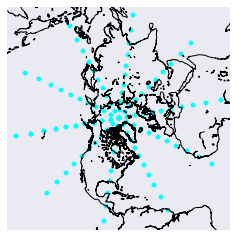

In [302]:
#look at lat-lon grid on basemap

xx_m = x_converted.flatten()*1000 + (m.xmax-m.xmin)/2.
yy_m = y_converted.flatten()*1000 + (m.ymax-m.ymin)/2.

m.scatter(xx_m,yy_m, marker='o',color='cyan')
m.drawcoastlines()

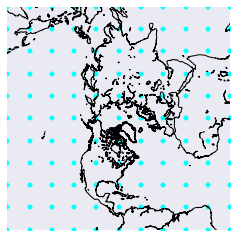

In [303]:
#look at xx,xx on basemap
xx_m = xx_reconstructed.flatten()*1000 + (m.xmax-m.xmin)/2.
yy_m = yy_reconstructed.flatten()*1000 + (m.ymax-m.ymin)/2.
m.scatter(xx_m,yy_m, marker='o',color='cyan')
m.drawcoastlines()

Results look similar to the sphereical model. We should have a good idea about the stereographic projections and how they distort uniform grids.

The IMS does not use a uniform grid. Knowing what we know, 

# IMS lat-lon files

It can be shown there are more points near the equator which begs the question? Why would there be more points at the equator for a snow and ice product?

Could it be there are more satalites collecting data at the equator? 

I don't understand why this is. All I can do is show you some plots. 

Basemap has a feature that can convert lat-lon to x,y without the code I wrote earlier. These were meant to be instructive. When creating map projections on your own, use basemap or pyproj libraries.

The code below takes the provided IMS lat-lon files and shows how latitude changes the grid approaches the equator.

In [305]:
#first I get the files and make them into nxn arrays.
import os
lat_filename = 'imslat_24km.bin'
lon_filename = 'imslon_24km.bin'
grid_size = 1024

with open(os.path.join(os.getcwd(),lat_filename), "r") as f:
    lat_array = np.fromfile(f, dtype=np.float32)               
    lat_matrix = lat_array.reshape(grid_size,grid_size)

with open(os.path.join(os.getcwd(),lon_filename), "r") as f:
    lon_array = np.fromfile(f, dtype=np.float32)
    lon_matrix = lon_array.reshape(grid_size,grid_size)


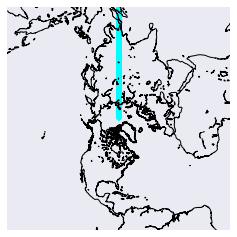

In [306]:
#I'm interested in showing the differences in latitude from the pole to the equator, 
#so I just take the top half of the middle column

lat = lat_matrix[:512,512]
lon = lon_matrix[:512,512]
lat = lat[~np.isnan(lat)]
lon = lon[~np.isnan(lon)]

#
x,y = m(lon, lat)

m.scatter(x,y, marker='o',color='cyan')
m.drawcoastlines()

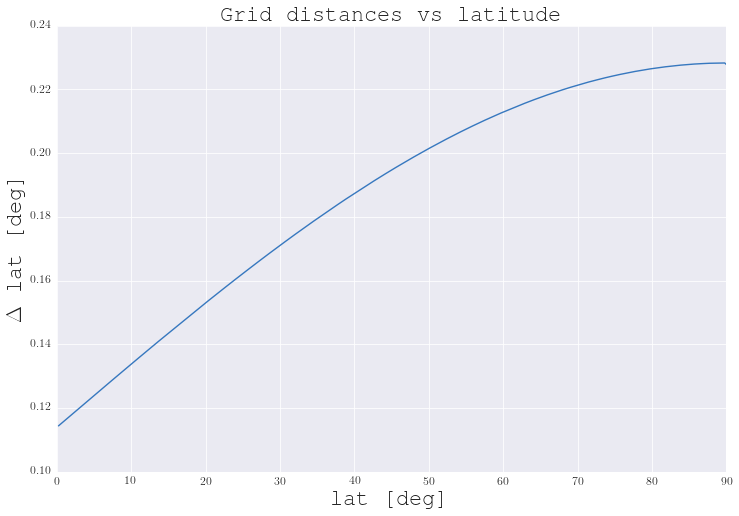

In [323]:
plt.figure(1, figsize=(12,8))
ax0 = plt.axes()
ax0.plot(lat[1:], np.diff(lat))
ax0.set_title('Grid distances vs latitude')
ax0.set_xlabel('lat [deg]')
ax0.set_ylabel('$\Delta$ lat [deg]')

In [327]:
print np.diff(lat).min()/np.diff(lat).max()

0.50145924

The smallest to largest ratio is almost $1/2$. Why the contrast?

# Conclusion

We have seen that IMS's data sets are not what they seem. Instead of an uniform grid, we are given a patchwork of points bearing little relation to the grids we created ourselves. 

I don't know how we could have determined the lat-lon coordinates of this grid ourselves, but am thankfull that the coordinates are provided on [IMS's page.](http://nsidc.org/data/docs/noaa/g02156_ims_snow_ice_analysis/index.html).

Moving forward, these files are crucial for precise measurements in snow coverage. With them we are able to transfer the data sets to any projection in the basemap library. 

This post was created using a jupyter notebook, and can be found [here.](https://github.com/tylertucker202/itsonlyamodel.posts)

Thanks for reading.

In [334]:
%%javascript
    MathJax.Hub.Queue(
      ["resetEquationNumbers", MathJax.InputJax.TeX],
      ["PreProcess", MathJax.Hub],
      ["Reprocess", MathJax.Hub]
    );

<IPython.core.display.Javascript object>